In [16]:
import pandas as pd
import xarray as xr
import intake

import util

In [17]:
cluster, client = util.get_ClusterClient()
cluster.adapt(minimum_jobs=2, maximum_jobs=5)
cluster

/glade/work/mclong/miniconda3/envs/sno/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36794 instead
  f"Port {expected} is already in use.\n"


In [19]:
cat = intake.open_catalog("catalogs/fluxes-catalog-web.yml")
cat

fluxes-catalog-web:
  args:
    path: catalogs/fluxes-catalog-web.yml
  description: Flux datasets
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [25]:
grid_1x1 = util.generate_latlon_grid(nx=360, ny=180, lon0=-180.)
grid_1x1

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, nv: 4)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    xc       (lat, lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    yc       (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    xv       (lat, lon, nv) float64 -180.0 -179.0 -179.0 ... 180.0 180.0 179.0
    yv       (lat, lon, nv) float64 -90.0 -90.0 -89.0 -89.0 ... 89.0 90.0 90.0
    area     (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08

In [27]:
%%time
def retrieve_dataset(value, add_time=False):
    try:
        ds = cat.fgco2_fff_odiac(year=value.year, month=value.month, day=value.day).to_dask()
        ds = ds.rename({"n_lon": "lon", "n_lat": "lat"})
        ds["lon"] = grid_1x1.lon
        ds["lat"] = grid_1x1.lon
        if add_time:
            ds["time"] = [cftime.datetime(*d) for d in ds.itime]
    except Exception:
        ds = None
        raise
    return ds


date_range = pd.date_range(start='2000-01-01', end='2000-01-02')
ds_list = client.map(retrieve_dataset, date_range)
ds_list = client.gather(ds_list)
#ds_list = [ds for ds in ds_list if ds is not None]
#ds = xr.concat(ds_list, dim='time', compat='override', coords='minimal').squeeze()
ds_list

CPU times: user 49.2 ms, sys: 22.2 ms, total: 71.3 ms
Wall time: 370 ms


[<xarray.Dataset>
 Dimensions:                (lon: 360, n_hour: 24, lat: 180, n_itime: 6)
 Coordinates:
   * lon                    (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
     lat                    (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
 Dimensions without coordinates: n_hour, n_itime
 Data variables:
     emission               (n_hour, lat, lon) float64 dask.array<chunksize=(24, 180, 360), meta=np.ndarray>
     surface_area           (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
     hourly_total_emission  (n_hour) float64 dask.array<chunksize=(24,), meta=np.ndarray>
     itime                  (n_hour, n_itime) int16 dask.array<chunksize=(24, 6), meta=np.ndarray>
 Attributes:
     total_emis:         18.27 TgC
     odiac_total:  Original ODIAC emission for this month =       18.94 TgC/day,
 <xarray.Dataset>
 Dimensions:                (lon: 360, n_hour: 24, lat: 180, n_itime: 6)
 Coordinates:
   * lon                    (lon) float64 

In [6]:
ds = xr.open_dataset("/glade/scratch/mclong/ODIAC_SFCO2_FFF/fossil_fuel_1x1_20171229.nc")
ds

<xarray.Dataset>
Dimensions:                (n_hour: 24, n_lat: 180, n_lon: 360, n_itime: 6)
Dimensions without coordinates: n_hour, n_lat, n_lon, n_itime
Data variables:
    emission               (n_hour, n_lat, n_lon) float64 ...
    surface_area           (n_lat, n_lon) float64 ...
    hourly_total_emission  (n_hour) float64 ...
    itime                  (n_hour, n_itime) int16 ...
Attributes:
    total_emis:         29.72 TgC
    odiac_total:  Original ODIAC emission for this month =        29.5 TgC/day

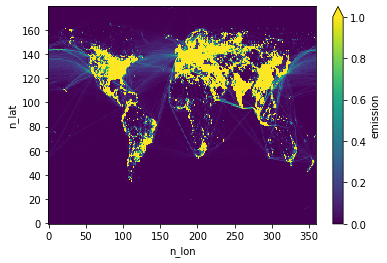

In [8]:
ds.emission.sum("n_hour").plot(vmax=1)

In [13]:
import cftime


[cftime.datetime(2017, 12, 29, 0, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 1, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 2, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 3, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 4, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 5, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 6, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 7, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 8, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 9, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 10, 30, 0, 0, calendar='gregorian', has_year_zero=False),
 cftime.datetime(2017, 12, 29, 

In [14]:
ds.itime

<xarray.DataArray 'itime' (n_hour: 24, n_itime: 6)>
array([[2017,   12,   29,    0,   30,    0],
       [2017,   12,   29,    1,   30,    0],
       [2017,   12,   29,    2,   30,    0],
       [2017,   12,   29,    3,   30,    0],
       [2017,   12,   29,    4,   30,    0],
       [2017,   12,   29,    5,   30,    0],
       [2017,   12,   29,    6,   30,    0],
       [2017,   12,   29,    7,   30,    0],
       [2017,   12,   29,    8,   30,    0],
       [2017,   12,   29,    9,   30,    0],
       [2017,   12,   29,   10,   30,    0],
       [2017,   12,   29,   11,   30,    0],
       [2017,   12,   29,   12,   30,    0],
       [2017,   12,   29,   13,   30,    0],
       [2017,   12,   29,   14,   30,    0],
       [2017,   12,   29,   15,   30,    0],
       [2017,   12,   29,   16,   30,    0],
       [2017,   12,   29,   17,   30,    0],
       [2017,   12,   29,   18,   30,    0],
       [2017,   12,   29,   19,   30,    0],
       [2017,   12,   29,   20,   30,    0],
       [2017,   12,   29,   21,   30,    0],
       [2017,   12,   29,   22,   30,    0],
       [2017,   12,   29,   23,   30,    0]], dtype=int16)
Dimensions without coordinates: n_hour, n_itime
Attributes:
    comment:  UTC time